In [1]:
import cv2 as cv
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import helpers as hp

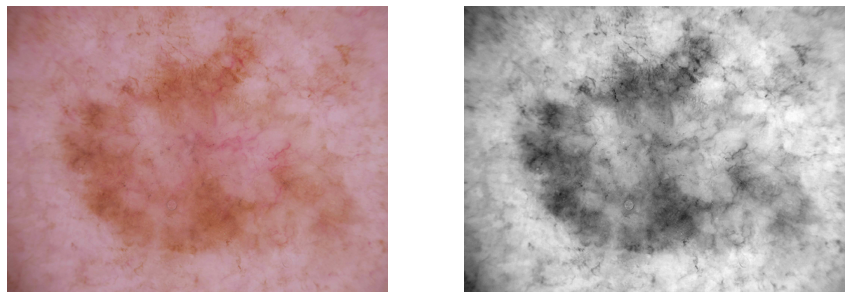

In [2]:
# it needs to convert the color code to display properly using matplotlib
# OpenCV uses BGR whereas matplotlib uses RGB
rgb_img = cv.cvtColor(cv.imread('./ham10k_images/ISIC_0029318.jpg'), cv.COLOR_BGR2RGB)
bw_img = cv.cvtColor(rgb_img, cv.COLOR_BGR2GRAY)

if rgb_img is None:
    print('Could not read RGB the image.')

if bw_img is None:
    print('Could not read B&W the image.')

fig, axes = plt.subplots(1, 2, figsize=(15,15))

for img, axe in zip([rgb_img, bw_img], [0, 1]):
    axes[axe].axis('off')
    axes[axe].imshow(img, cmap='gray')

In [3]:
test = cv.resize(rgb_img, (256, 256))

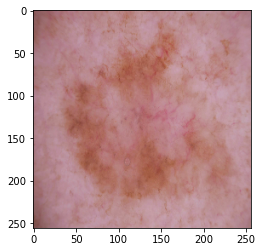

In [4]:
plt.imshow(test)

## B&W 

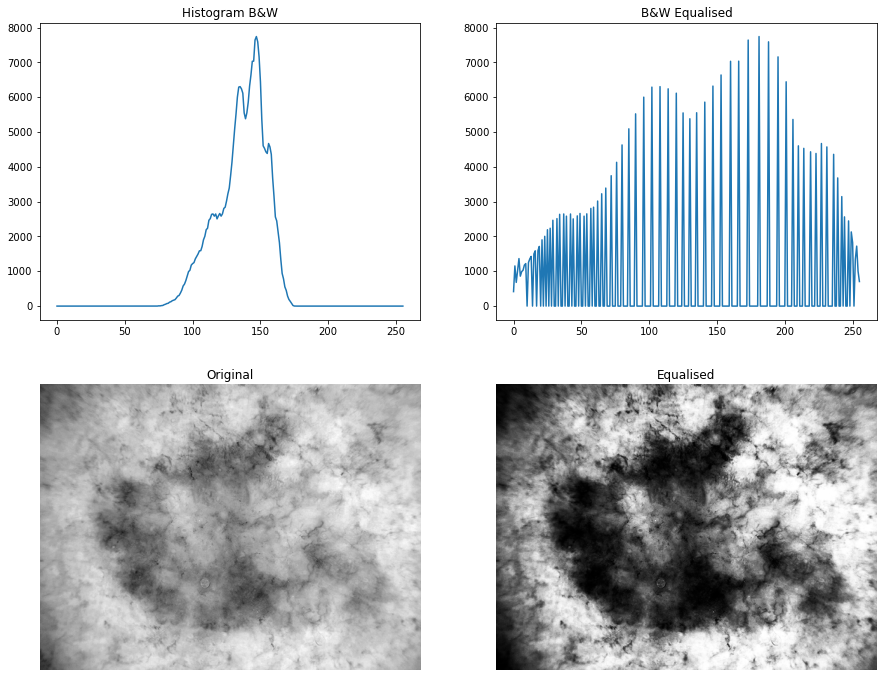

In [5]:
hp.compare_hist(bw_img)

## RGB

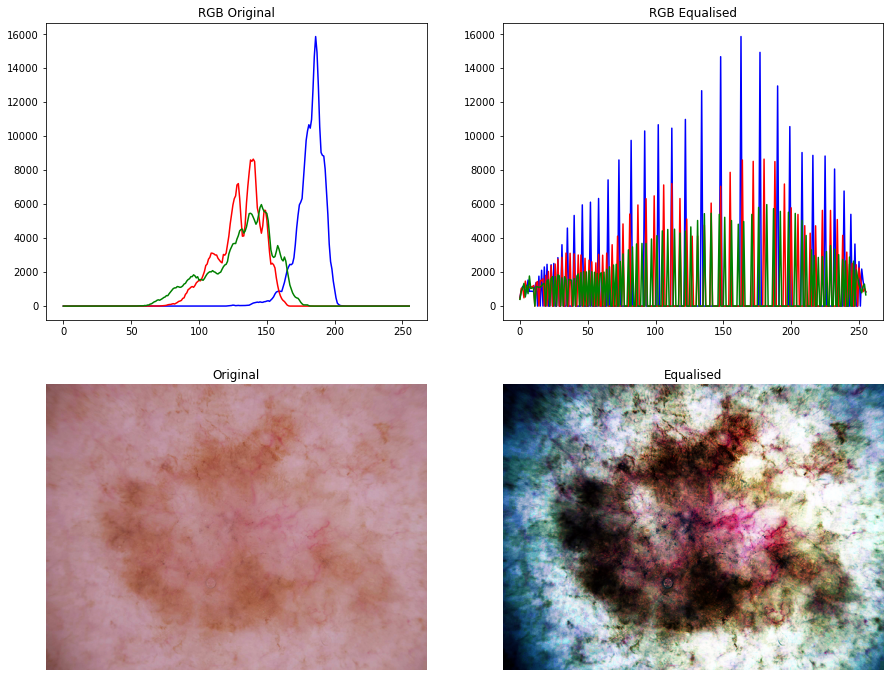

In [7]:
hp.compare_hist(rgb_img, bw=False)

## Metadata

In [2]:
ham10k_df = pd.read_csv('./metadata/HAM10000_metadata.csv', index_col='image_id')

In [3]:
ham10k_df.sort_index(inplace=True)
ham10k_df.head()

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0024306,HAM_0000550,nv,follow_up,45.0,male,trunk
ISIC_0024307,HAM_0003577,nv,follow_up,50.0,male,lower extremity
ISIC_0024308,HAM_0001477,nv,follow_up,55.0,female,trunk
ISIC_0024309,HAM_0000484,nv,follow_up,40.0,male,trunk
ISIC_0024310,HAM_0003350,mel,histo,60.0,male,chest


In [ ]:
import fnmatch

In [4]:
dirname = os.path.relpath('./ham10k_images/')
print(dirname)

ham10k_images


In [5]:
filenames = os.listdir(dirname)

In [6]:
list(map(lambda x: os.path.splitext(x)[0], sorted(filenames))) == ham10k_df.index.tolist()

True

In [7]:
for dirname, _, filenames in os.walk(dirname):
    for filename in filenames:
        # get the img id by removing file extension
        img_id, _ = os.path.splitext(filename)
        if img_id in ham10k_df.index:
            print(img_id)
            break

ISIC_0030858


In [ ]:
img_dict = {}

for filename in filenames:
    # remove extension
    image_id, _ = os.path.splitext(filename)
    print(image_id)
    img = cv.cvtColor(cv.imread(dirname + '/' + filename), cv.COLOR_BGR2RGB)
    #plt.imshow(img)
    ham10k_df.loc[image_id, 'pixel_repr'] = np.asarray(img)
    break

In [ ]:
img = cv.cvtColor(cv.imread(dirname + '/' + filename), cv.COLOR_BGR2RGB)

In [ ]:
type(img)

In [ ]:
ham10k_df.iloc[0]

In [ ]:
ham10k_df[ham10k_df['image_id'] == 'ISIC_0029318']

In [ ]:
ham10k_df.groupby('sex').localization.value_counts().unstack().plot(kind='bar', figsize=(15,10), cmap='viridis')

In [ ]:
ham10k_df.isna().sum()

In [ ]:
ham10k_df.info()

In [ ]:
ham10k_df.head(10)

In [ ]:
ham10k_df.dx.value_counts().plot(kind='bar')

In [ ]:
ham10k_df.groupby('sex').dx.value_counts().unstack().plot(kind='barh',
                                                         figsize=(10,10),
                                                         cmap='viridis')

In [ ]:
sns.catplot(x='sex', kind='count', hue='dx', 
            data=ham10k_df[ham10k_df.localization == 'scalp'], 
            palette='viridis')

In [ ]:
ham10k_df.sex.value_counts().plot(kind='bar')

In [ ]:
ham10k_df.image_id.unique().shape

In [ ]:
ham10k_df.lesion_id.unique().shape

In [ ]:
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(ham10k_df.sex.value_counts().values, explode=(0.1, 0, 0), labels=ham10k_df.sex.unique(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.rc('font', size=15)
plt.rc('axes', labelsize=20)
plt.title('Images Distribution by Sex')


In [ ]:
list(map(lambda x: x.upper(), ham10k_df.sex.unique().tolist()))

In [ ]:
ham10k_df.groupby('localization').dx.value_counts().unstack().plot(kind='bar', figsize=(15,10), cmap='viridis')

In [ ]:
sns.histplot(ham10k_df, x="dx", y='localization');

In [ ]:
plt.imshow(bw_img, cmap='gray')

In [ ]:
ret, thresh = cv.threshold(bw_eq,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

In [ ]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

In [ ]:
plt.imshow(sure_bg, cmap='gray')

In [ ]:
plt.imshow(sure_fg, cmap='gray')

In [ ]:
plt.imshow(unknown, cmap='gray')

In [ ]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [ ]:
plt.imshow(markers, cmap='gray')

In [ ]:
ret,thresh = cv.threshold(bw_eq,127,255,0)
contours,hierarchy = cv.findContours(thresh, 1, 2)
cnt = contours[0]
M = cv.moments(cnt)
print( M )

In [ ]:
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

area = cv.contourArea(cnt)
perimeter = cv.arcLength(cnt,True)

epsilon = 0.1*cv.arcLength(cnt,True)
approx = cv.approxPolyDP(cnt,epsilon,True)

In [ ]:
for contour in contours:
   cv.drawContours(bw_eq, contour, -1, (0, 255, 0), 3)
plt.figure()
plt.imshow(bw_eq, cmap='gray')

In [ ]:
edged = cv.Canny(bw_eq, 0, 150)
plt.imshow(edged, cmap='gray')

In [ ]:
rgb_img.shape